In [68]:
import os
from keras.preprocessing.image import ImageDataGenerator 
# https://keras.io/api/preprocessing/image/#image-data-preprocessing
from keras.applications.imagenet_utils import preprocess_input

from keras.applications.vgg16 import VGG16

from keras.models import Model, Sequential

from keras.layers import Dense, Flatten, Dropout

from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.metrics import accuracy

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix

ERROR! Session/line number was not unique in database. History logging moved to new session 109


Verificando si las carpetas necesarias estan disponibles

In [35]:
pathTrain = './dataset/catdog/train'
pathTest = './dataset/catdog/test'

if (os.path.exists(pathTrain) and os.path.exists(pathTest)):
    print('OK')
else:
    print('No existen carpetas')
    print('Descomprima el archivo catdog.zip o puede descargar otro dataset: https://www.kaggle.com/arpitjain007/dog-vs-cat-fastai')


OK


Crear un generador de nuevas imagenes

In [36]:
images_increased = 5
width_shape = 224
height_shape = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rotation_range=20, # rota 20 grados
    zoom_range=0.2, # zoom
    width_shift_range=0.1, # desplazar 10%
    height_shift_range=0.1,  # desplazar 10%
    horizontal_flip=True, # invertir horizontalmente
    vertical_flip=False,
    preprocessing_function=preprocess_input
)

valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(  
    pathTrain,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = valid_datagen.flow_from_directory(  
    pathTest,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='binary')

Found 400 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


Crear modelo

In [37]:
inputShape = (height_shape, width_shape, 3)

model = VGG16(include_top=False, weights="imagenet", input_shape=inputShape)

Configurar capas para no se entrenadas. Frezar las primeras 10 capas

In [38]:
for layer in model.layers[:10]:
    layer.trainable = False

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)


0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


Generar función que agrega capas en la etapa de clasificación

In [51]:
def load_fc_layers(model):
    # add new classifier layers
    newModel = Sequential()
    newModel.add(model)
    newModel.add(Flatten())
    newModel.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    newModel.add(Dropout(rate=0.1))
    newModel.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    newModel.add(Dense(1, activation='sigmoid'))
    
    return newModel

In [52]:
fullModel = load_fc_layers(model)
for i, layer in enumerate(fullModel.layers):
    print(i, layer.name, layer.trainable)

fullModel.summary()

0 vgg16 True
1 flatten_8 True
2 dense_17 True
3 dropout_1 True
4 dense_18 True
5 dense_19 True
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 17,934,401


Compilar

In [54]:
adam = Adam(learning_rate=0.1)

fullModel.compile(
    optimizer=adam,
    loss=binary_crossentropy,
    metrics=[accuracy]
)

Entrenar

In [55]:
epoch = 100

history = fullModel.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=epoch,
    verbose=False
)

Epoch 1/100
13/13 [==============================] - 9s 671ms/step - loss: 949.3373 - accuracy: 0.2925 - val_loss: 0.7037 - val_accuracy: 0.0000e+00
Epoch 2/100
13/13 [==============================] - 8s 609ms/step - loss: 0.9680 - accuracy: 0.0000e+00 - val_loss: 0.7048 - val_accuracy: 0.0000e+00
Epoch 3/100
13/13 [==============================] - 8s 608ms/step - loss: 0.7102 - accuracy: 0.0000e+00 - val_loss: 0.6939 - val_accuracy: 0.0000e+00
Epoch 4/100
13/13 [==============================] - 8s 608ms/step - loss: 0.6950 - accuracy: 0.0000e+00 - val_loss: 0.6937 - val_accuracy: 0.0000e+00
Epoch 5/100
13/13 [==============================] - 8s 608ms/step - loss: 0.6936 - accuracy: 0.0000e+00 - val_loss: 0.6932 - val_accuracy: 0.0000e+00
Epoch 6/100
13/13 [==============================] - 8s 610ms/step - loss: 0.6952 - accuracy: 0.0000e+00 - val_loss: 0.6934 - val_accuracy: 0.0000e+00
Epoch 7/100
13/13 [==============================] - 8s 608ms/step - loss: 0.6966 - accuracy: 0.

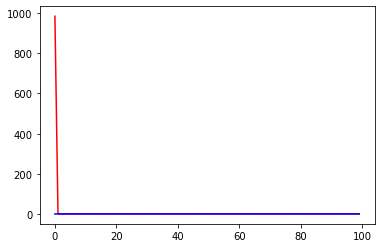

In [56]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], color='red')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], color='blue')

plt.show()

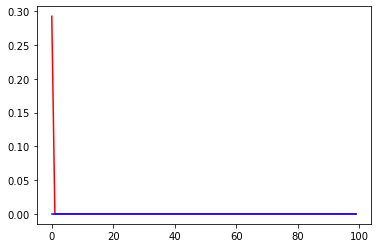

In [58]:
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], color='red')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], color='blue')

plt.show()

Matriz de confusión

In [70]:
Y_pred = fullModel.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

print('Classification Report')
target_names = ['Cats', 'Dogs']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

ERROR! Session/line number was not unique in database. History logging moved to new session 110
Confusion Matrix
[[10  0]
 [10  0]]
Classification Report
              precision    recall  f1-score   support

        Cats       0.50      1.00      0.67        10
        Dogs       0.00      0.00      0.00        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20

C:\Users\vicen\anaconda3\envs\utnia\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vicen\anaconda3\envs\utnia\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with 